# Assignment 3

Spiral Excitation pulses


In [70]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import torch
import sys

from csg import *
from ktog import *
from ktos import *
from ab2ex import *
from abrm import *

from scipy.special import j1
def jinc(r):
    #
    return j1(r*np.pi)/(2*r)

def rect(r):
    #1 from -0.5 to 0.5. 
    #rect(r/(2*kmax)) yields 1 from -kmax to kmax. 
    return 0.5*(np.sign(r+0.5) + np.sign(0.5 - r))


In [71]:
 #Hz/Gauss; the 1T gyromagnetic ratio. 
gyro = 4257# 


##INPUTS
dR = 0.5#cm
side_lobe = 8#cm
g_max = 4 #G/cm
slew_max= 15#G/cm/ms
jinc_excitation_diameter = 4#cm
flip_angle = np.pi/2 

def create_rf_pulse( dR, side_lobe, g_max, slew_max, jinc_excitation_diameter, flip_angle):
    #Calculate kmax: 
    #gyro/2pi*G*dZ = 4kHz
    kmax = gyro/(2*np.pi) *g_max * dR#
    kmax = kmax/1E3 #normalize to khz
    #print(f"kmax for 0.5cm resolution: {kmax} KHz")

    #Calculate N_turns: 
    #dR = 1/(2*k_max)
    #FOV_sidelobe=1/dK=2N/2kmax
    #side_lobe = 2*N_turns*dR
    N_turns = side_lobe/dR/2 #8*dZ/2 
    #print(f"N_turns for {side_lobe}cm sidelobe: {N_turns}")

    t = np.linspace(0,1,2048)
    ka = kmax*(1-t) * np.exp(1j*2*np.pi*N_turns*(1-t)) #1-t is for time reversal of excitation

    k,dt = csg(ka,g_max,slew_max) #(ka, gmax,slewmax)
    #change slew rates to reach limits of the machine. 
    #look at new gradients:
    g = ktog(k,dt)
    s = ktos(k,dt)

    #Create weighting: 
    N_jinc = jinc_excitation_diameter/2 * 1/dR
    w_k = jinc(N_jinc*np.abs(k)/kmax)*rect(np.abs(k)/(kmax*2)) #k is position in k-space over time, w_k is weighting factor. 

    ##Apply weighting to gradients:
    #RF pulse with gradient and weighting:
    rf_density = np.abs(g)* w_k[:-1]  #RF density is the rate of the gradient times its w_k position. 
    #How much power are you depositing per dt at each position w(k)?  
    rf = rf_density /sum(rf_density) * flip_angle# #normalize to 90deg flip angle 

    return w_k, k, rf, dt, g, s, kmax




Gradient duration is  8.571 ms


/tmp/ipykernel_2082/1963788447.py:16: RuntimeWarning: invalid value encountered in divide
  return j1(r*np.pi)/(2*r)


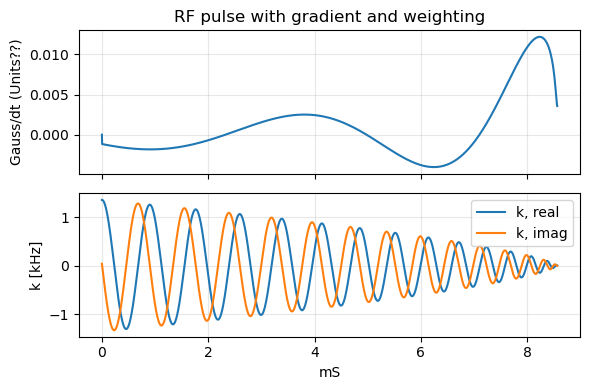

Gradient duration is  8.571 ms


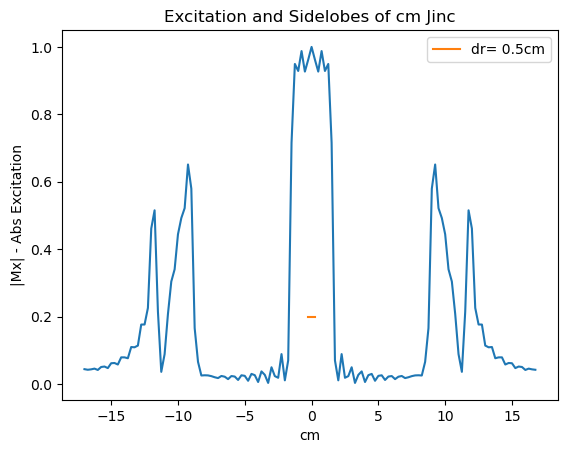

In [72]:
w_k, k, rf, dt, g, s, kmax = create_rf_pulse( dR=0.5, side_lobe=14, 
                                            g_max=4, slew_max=15, 
                                            jinc_excitation_diameter=4, flip_angle=np.pi/2)



t_ms = np.linspace(0, dt*len(g), num=len(g))
fig, axes = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
# Top subplot: RF pulse vs time
axes[0].plot(t_ms, rf)
axes[0].set_title("RF pulse with gradient and weighting")
axes[0].set_ylabel("Gauss/dt (Units??)")
axes[0].grid(True, alpha=0.3)
# Bottom subplot: k-space real/imag vs time
axes[1].plot(t_ms, np.real(k)[:-1], label="k, real")
axes[1].plot(t_ms, np.imag(k)[:-1], label="k, imag")
axes[1].set_xlabel("mS")
axes[1].set_ylabel("k [kHz]")
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

w_k, k, rf, dt, g, s, kmax = create_rf_pulse( dR=0.5, side_lobe=14, 
                                            g_max=4, slew_max=15, 
                                            jinc_excitation_diameter=4, flip_angle=np.pi/2)


gs = 2*np.pi*4.257*g*dt  #g is G/cm gradfield, gs is spatial freq; gamma*g*dt in kHz. 
x = np.arange(-17,17, 0.25)
a,b = abrm(rf,gs,x)
mxy1 = ab2ex(a,b)

plt.figure()
plt.title("Excitation and Sidelobes of cm Jinc")
plt.xlabel("cm")
plt.ylabel("|Mx| - Abs Excitation")
plt.plot(x,np.abs(mxy1))
plt.plot([-0.25,0.25],[0.2,0.2], label="dr= 0.5cm")
plt.legend()





Gradient duration is  8.571 ms


/tmp/ipykernel_2082/1963788447.py:16: RuntimeWarning: invalid value encountered in divide
  return j1(r*np.pi)/(2*r)


Gradient duration is  4.923 ms


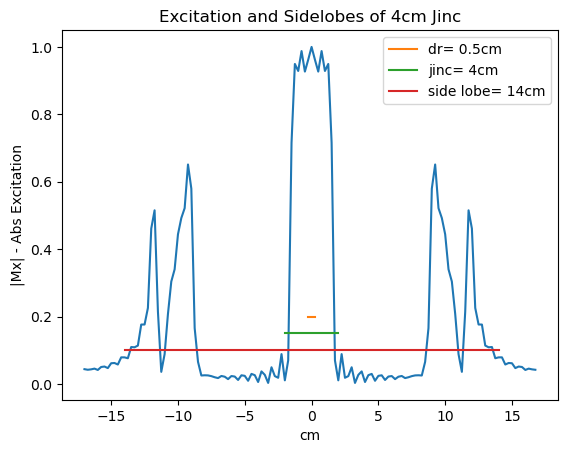

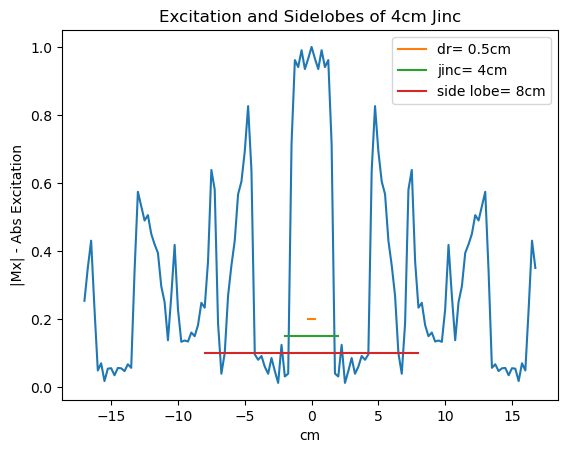

In [73]:

dR = 0.5
side_lobe =14
jinc_excitation_diameter = 4
w_k, k, rf, dt, g, s, kmax = create_rf_pulse( dR=dR, side_lobe=side_lobe, 
                                            g_max=4, slew_max=15, 
                                            jinc_excitation_diameter=jinc_excitation_diameter, flip_angle=np.pi/2)


gs = 2*np.pi*4.257*g*dt  #g is G/cm gradfield, gs is spatial freq; gamma*g*dt in kHz. 
x = np.arange(-17,17, 0.25)
a,b = abrm(rf,gs,x)
mxy1 = ab2ex(a,b)

plt.figure()
plt.title(f"Excitation and Sidelobes of {jinc_excitation_diameter}cm Jinc")
plt.xlabel("cm")
plt.ylabel("|Mx| - Abs Excitation")
plt.plot(x,np.abs(mxy1))
plt.plot([-dR/2,dR/2],[0.2,0.2], label=f"dr= {dR}cm")
plt.plot([-jinc_excitation_diameter/2,jinc_excitation_diameter/2],[0.15,0.15], label=f"jinc= {jinc_excitation_diameter}cm")
plt.plot([-side_lobe,side_lobe],[0.1,0.1], label=f"side lobe= {side_lobe}cm")
plt.legend()


dR = 0.5
side_lobe =8
jinc_excitation_diameter = 4
w_k, k, rf, dt, g, s, kmax = create_rf_pulse( dR=dR, side_lobe=side_lobe, 
                                            g_max=4, slew_max=15, 
                                            jinc_excitation_diameter=jinc_excitation_diameter, flip_angle=np.pi/2)


gs = 2*np.pi*4.257*g*dt  #g is G/cm gradfield, gs is spatial freq; gamma*g*dt in kHz. 
x = np.arange(-17,17, 0.25)
a,b = abrm(rf,gs,x)
mxy1 = ab2ex(a,b)

plt.figure()
plt.title(f"Excitation and Sidelobes of {jinc_excitation_diameter}cm Jinc")
plt.xlabel("cm")
plt.ylabel("|Mx| - Abs Excitation")
plt.plot(x,np.abs(mxy1))
plt.plot([-dR/2,dR/2],[0.2,0.2], label=f"dr= {dR}cm")
plt.plot([-jinc_excitation_diameter/2,jinc_excitation_diameter/2],[0.15,0.15], label=f"jinc= {jinc_excitation_diameter}cm")
plt.plot([-side_lobe,side_lobe],[0.1,0.1], label=f"side lobe= {side_lobe}cm")
plt.legend()



Gradient duration is 12.224 ms


/tmp/ipykernel_2082/1963788447.py:16: RuntimeWarning: invalid value encountered in divide
  return j1(r*np.pi)/(2*r)
/tmp/ipykernel_2082/2603362494.py:84: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


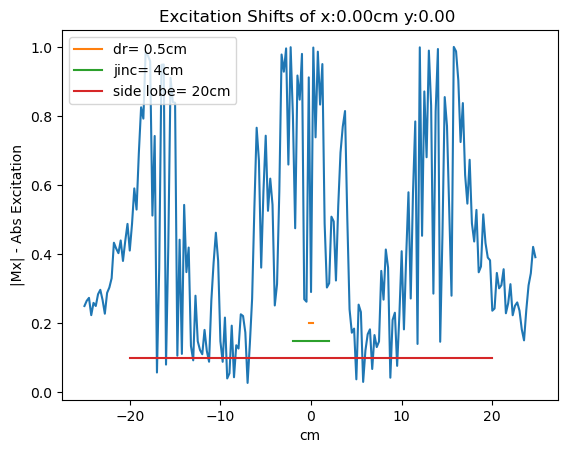

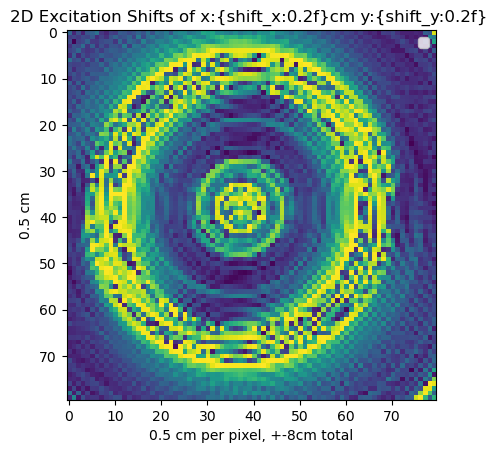

In [99]:
#Question 3: shifting volume
#Demo Lecture 5, slide 4
#12 turn spiral, 4.5mS constant slew rate,
#1cm resolution, (kmax = +-0.5cyc/cm)
#SBW =4, windowed jinc RF
#side lobes at +- 24cm, and +- 48cm

dR = 0.5
side_lobe =20
jinc_excitation_diameter = 4

 #Calculate kmax: 
#gyro/2pi*G*dZ = 4kHz
kmax = gyro/(2*np.pi) *g_max * dR#
kmax = kmax/1E3 #normalize to khz
#print(f"kmax for 0.5cm resolution: {kmax} KHz")

#Calculate N_turns: 
#dR = 1/(2*k_max)
#FOV_sidelobe=1/dK=2N/2kmax
#side_lobe = 2*N_turns*dR
N_turns = side_lobe/dR/2 #8*dZ/2 
#print(f"N_turns for {side_lobe}cm sidelobe: {N_turns}")

t = np.linspace(0,1,2048)
ka = kmax*(1-t) * np.exp(1j*2*np.pi*N_turns*(1-t)) #1-t is for time reversal of excitation

k,dt = csg(ka,g_max,slew_max) #(ka, gmax,slewmax)
#change slew rates to reach limits of the machine. 
#look at new gradients:
g = ktog(k,dt)
s = ktos(k,dt)

#Create weighting: 
x_shift = 4 #cm
y_shift = 6 #cm
N_jinc = jinc_excitation_diameter/2 * 1/dR
w_k = jinc(N_jinc*np.abs(k)/kmax)*rect(np.abs(k)/(kmax*2)) #k is position in k-space over time, w_k is weighting factor. 
w_k = w_k * np.exp(-1j * x_shift/ (gamma*g_max*dt) * np.real(k)) * np.exp(-1j * y_shift/ (gamma*g_max*dt) * np.imag(k))

##Apply weighting to gradients:
#RF pulse with gradient and weighting:
rf_density = np.abs(g)* w_k[:-1]  #RF density is the rate of the gradient times its w_k position. 
#How much power are you depositing per dt at each position w(k)?  
rf = rf_density /sum(rf_density) * flip_angle# #normalize to 90deg flip angle 







gs = 2*np.pi*4.257*g*dt  #g is G/cm gradfield, gs is spatial freq; gamma*g*dt in kHz. 
x = np.arange(-25,25, 0.25)
a,b = abrm(rf,gs,x)
mxy1 = ab2ex(a,b)

plt.figure()
plt.title(f"Excitation Shifts of x:{shift_x:0.2f}cm y:{shift_y:0.2f} ")
plt.xlabel("cm")
plt.ylabel("|Mx| - Abs Excitation")
plt.plot(x,np.abs(mxy1))
plt.plot([-dR/2,dR/2],[0.2,0.2], label=f"dr= {dR}cm")
plt.plot([-jinc_excitation_diameter/2,jinc_excitation_diameter/2],[0.15,0.15], label=f"jinc= {jinc_excitation_diameter}cm")
plt.plot([-side_lobe,side_lobe],[0.1,0.1], label=f"side lobe= {side_lobe}cm")
plt.legend()


step = 0.5
x = np.arange(-20,20, step)
y = np.arange(-20,20, step)

gs = 2*np.pi*4.257*g*dt  #g is G/cm gradfield, gs is spatial freq; gamma*g*dt in kHz. 
a,b = abrm(rf,gs,x,y)
mxy2 = ab2ex(a,b)

plt.figure()
plt.title("2D Excitation Shifts of x:{shift_x:0.2f}cm y:{shift_y:0.2f} ")
plt.xlabel(f"{step} cm per pixel, +-8cm total")
plt.ylabel(f"{step} cm")
#plt.ylabel("|Mx| - Abs Excitation")
plt.imshow(np.abs(mxy2), label="|Mxy| excitation")
#plt.plot([-0.25,0.25],[0.2,0.2], label="dr= 0.5cm")
plt.legend()

Gradient duration is 12.224 ms


/tmp/ipykernel_2082/1963788447.py:16: RuntimeWarning: invalid value encountered in divide
  return j1(r*np.pi)/(2*r)
/tmp/ipykernel_2082/462180242.py:84: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


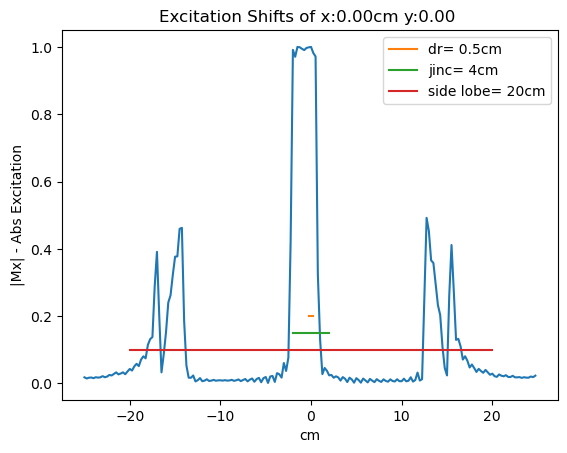

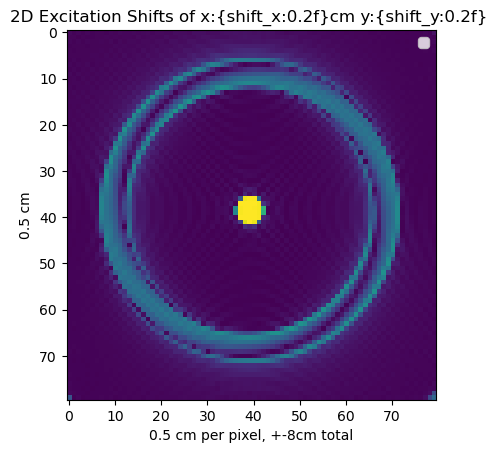

In [ ]:
#Question 3: shifting volume
#Demo Lecture 5, slide 4
#12 turn spiral, 4.5mS constant slew rate,
#1cm resolution, (kmax = +-0.5cyc/cm)
#SBW =4, windowed jinc RF
#side lobes at +- 24cm, and +- 48cm

dR = 0.5
side_lobe =20
jinc_excitation_diameter = 4

 #Calculate kmax: 
#gyro/2pi*G*dZ = 4kHz
kmax = gyro/(2*np.pi) *g_max * dR#
kmax = kmax/1E3 #normalize to khz
#print(f"kmax for 0.5cm resolution: {kmax} KHz")

#Calculate N_turns: 
#dR = 1/(2*k_max)
#FOV_sidelobe=1/dK=2N/2kmax
#side_lobe = 2*N_turns*dR
N_turns = side_lobe/dR/2 #8*dZ/2 
#print(f"N_turns for {side_lobe}cm sidelobe: {N_turns}")

t = np.linspace(0,1,2048)
ka = kmax*(1-t) * np.exp(1j*2*np.pi*N_turns*(1-t)) #1-t is for time reversal of excitation

k,dt = csg(ka,g_max,slew_max) #(ka, gmax,slewmax)
#change slew rates to reach limits of the machine. 
#look at new gradients:
g = ktog(k,dt)
s = ktos(k,dt)

#Create weighting: 
x_shift = 3 #cm
y_shift = 2 #cm
N_jinc = jinc_excitation_diameter/2 * 1/dR
w_k = jinc(N_jinc*np.abs(k)/kmax)*rect(np.abs(k)/(kmax*2)) #k is position in k-space over time, w_k is weighting factor. 
w_k = w_k * np.exp(-1j * x_shift/ (gamma*g_max*dt) * np.real(k)) * np.exp(-1j * y_shift/ (gamma*g_max*dt) * np.imag(k))

##Apply weighting to gradients:
#RF pulse with gradient and weighting:
rf_density = np.abs(g)* w_k[:-1]  #RF density is the rate of the gradient times its w_k position. 
#How much power are you depositing per dt at each position w(k)?  
rf = rf_density /sum(rf_density) * flip_angle# #normalize to 90deg flip angle 







gs = 2*np.pi*4.257*g*dt  #g is G/cm gradfield, gs is spatial freq; gamma*g*dt in kHz. 
x = np.arange(-25,25, 0.25)
a,b = abrm(rf,gs,x)
mxy1 = ab2ex(a,b)

plt.figure()
plt.title(f"Excitation Shifts of x:{shift_x:0.2f}cm y:{shift_y:0.2f} ")
plt.xlabel("cm")
plt.ylabel("|Mx| - Abs Excitation")
plt.plot(x,np.abs(mxy1))
plt.plot([-dR/2,dR/2],[0.2,0.2], label=f"dr= {dR}cm")
plt.plot([-jinc_excitation_diameter/2,jinc_excitation_diameter/2],[0.15,0.15], label=f"jinc= {jinc_excitation_diameter}cm")
plt.plot([-side_lobe,side_lobe],[0.1,0.1], label=f"side lobe= {side_lobe}cm")
plt.legend()


step = 0.5
x = np.arange(-20,20, step)
y = np.arange(-20,20, step)

gs = 2*np.pi*4.257*g*dt  #g is G/cm gradfield, gs is spatial freq; gamma*g*dt in kHz. 
a,b = abrm(rf,gs,x,y)
mxy2 = ab2ex(a,b)

plt.figure()
plt.title(f"2D Excitation Shifts of x:{shift_x:0.2f}cm y:{shift_y:0.2f} ")
plt.xlabel(f"{step} cm per pixel, +-8cm total")
plt.ylabel(f"{step} cm")
#plt.ylabel("|Mx| - Abs Excitation")
plt.imshow(np.abs(mxy2), label="|Mxy| excitation")
#plt.plot([-0.25,0.25],[0.2,0.2], label="dr= 0.5cm")
plt.legend()

FOV estimate = 10 cycles
Gradient duration is  9.705 ms


/root/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/root/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


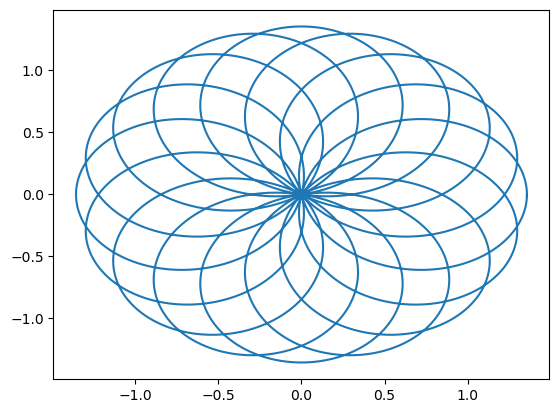

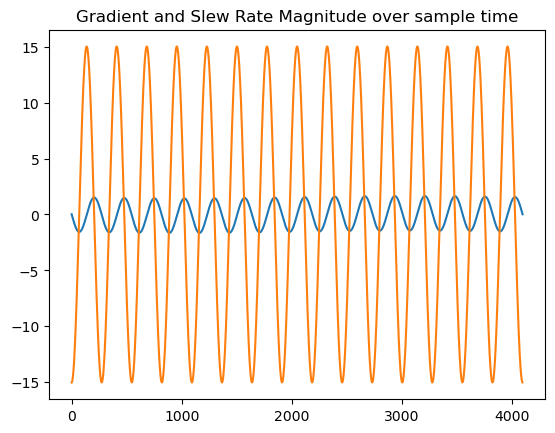

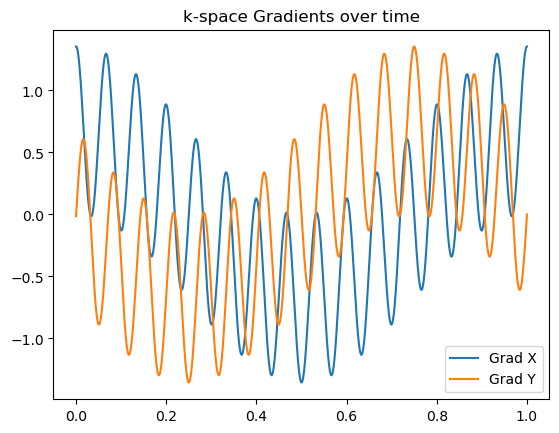

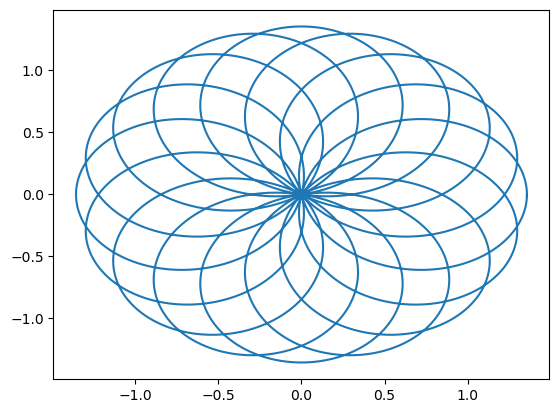

In [ ]:
#Q3: Rosette Density Estimation
t = np.linspace(0,1,4096)
ka = kmax*np.cos(2*np.pi*8*t)*np.exp(1j*2*np.pi*7*t)
plt.plot(np.real(k), np.imag(k))
#a.) FOV, there are roughly 6 crossings from 0 to kmax along an arc.So I think that will have an FOV of a ~5 turn spiral. 
# spiral is FOV=2*Nturns*dr. 
print(f"FOV estimate = 6 cycles = 3cm")


#Calculate kmax: 
g_max = 4
slew_max = 15
dR = 0.5
kmax = gyro/(2*np.pi) *g_max * dR#
kmax = kmax/1E3 #normalize to khz

t = np.linspace(0,1,4096)
ka = kmax*np.cos(2*np.pi*8*t)*np.exp(1j*2*np.pi*7*t)
k,dt = csg(ka,g_max,slew_max) #(ka, gmax,slewmax)
#change slew rates to reach limits of the machine. 
#look at new gradients:
plt.figure()
plt.title("Gradient and Slew Rate Magnitude over sample time")
g = ktog(k,dt,)
s = ktos(k,dt)
plt.plot(g)
plt.plot(s)

plt.figure()
plt.title("k-space Gradients over time")
plt.plot(t, np.real(k), label="Grad X")
plt.plot(t, np.imag(k), label="Grad Y")
plt.legend()
plt.figure()
plt.plot(np.real(k), np.imag(k))


/tmp/ipykernel_2082/2767450534.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


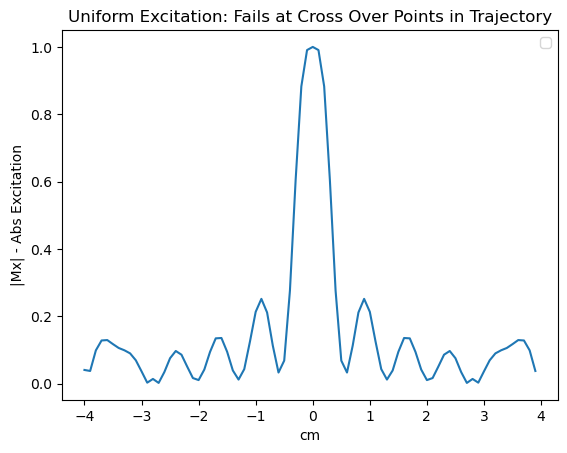

In [146]:
flip_angle = np.pi/2
##Apply weighting to gradients:
#RF pulse with gradient and weighting:
rf_density = np.abs(g)# w_k[:-1]  #RF density is the rate of the gradient times its w_k position. 
#How much power are you depositing per dt at each position w(k)?  
rf = rf_density /sum(rf_density) * flip_angle# #normalize to 90deg flip angle 



gs = 2*np.pi*4.257*g*dt  #g is G/cm gradfield, gs is spatial freq; gamma*g*dt in kHz. 
x = np.arange(-4,4, 0.1)
a,b = abrm(rf,gs,x)
mxy1 = ab2ex(a,b)

no_density_comp =np.abs(mxy1)

rf_no_density_comp = rf
gs_no_density_comp = gs

plt.figure()
plt.title(f"Uniform Excitation: Fails at Cross Over Points in Trajectory")
plt.xlabel("cm")
plt.ylabel("|Mx| - Abs Excitation")
plt.plot(x,no_density_comp)
plt.legend()




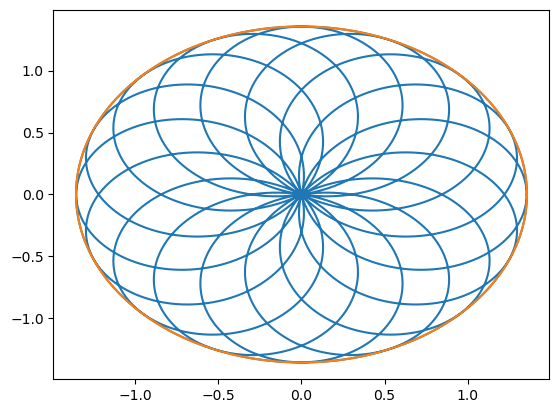

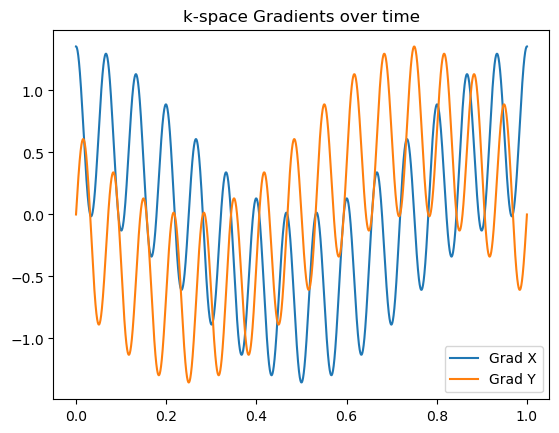

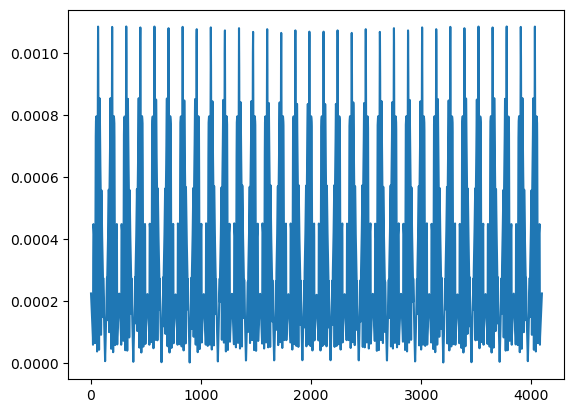

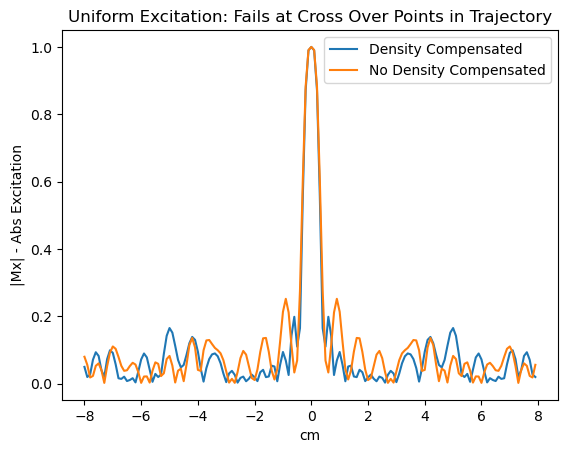

In [148]:
#Q3: Rosette Density Estimation
from voronoidens import voronoidens, plot_voronoi_diagram

t = np.linspace(0,1,4096)
ka = kmax*np.cos(2*np.pi*8*t)*np.exp(1j*2*np.pi*7*t)
kp = kmax * (1+1E-3) * np.exp(1j*2*np.pi*np.linspace(0,1,1024))
plt.plot(np.real(k), np.imag(k))
plt.plot(np.real(kp), np.imag(kp))

k = np.concatenate((ka,kp))
kx = np.real(k)  # Real part of k-space
ky = np.imag(k)  # Imaginary part of k-space

# Calculate areas
dp = voronoidens(np.real(k), np.imag(k))
d = dp[:-1024]
rf_density = d 

rf = rf_density /sum(rf_density) * flip_angle# #normalize to 90deg flip angle 

plt.figure()
plt.title("k-space Gradients over time")
plt.plot(t, np.real(ka), label="Grad X")
plt.plot(t, np.imag(ka), label="Grad Y")
plt.legend()
plt.figure()
#plt.plot(np.real(ka), np.imag(ka))
plt.plot(rf)




gs = 2*np.pi*4.257*g*dt  #g is G/cm gradfield, gs is spatial freq; gamma*g*dt in kHz. 
x = np.arange(-8,8, 0.1)
a,b = abrm(rf[:-1],gs,x)
mxy1 = ab2ex(a,b)


a2,b2 = abrm(rf_no_density_comp,gs_no_density_comp,x)
mxy1_no_density_comp = ab2ex(a2,b2)



plt.figure()
plt.title(f"Uniform Excitation: Fails at Cross Over Points in Trajectory")
plt.xlabel("cm")
plt.ylabel("|Mx| - Abs Excitation")
plt.plot(x,np.abs(mxy1),label="Density Compensated")
plt.plot(x,np.abs(mxy1_no_density_comp),label="No Density Compensated")
plt.legend()




/tmp/ipykernel_2082/2517386734.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


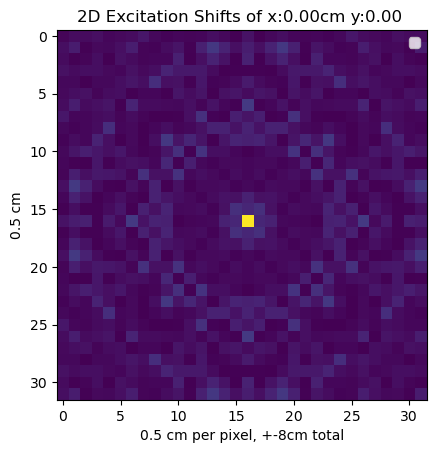

In [141]:

step = 0.5
x = np.arange(-8,8, step)
y = np.arange(-8,8, step)

gs = 2*np.pi*4.257*g*dt  #g is G/cm gradfield, gs is spatial freq; gamma*g*dt in kHz. 
a,b = abrm(rf[:-1],gs,x,y)
mxy2 = ab2ex(a,b)

plt.figure()
plt.title(f"2D Excitation Shifts of x:{shift_x:0.2f}cm y:{shift_y:0.2f} ")
plt.xlabel(f"{step} cm per pixel, +-8cm total")
plt.ylabel(f"{step} cm")
#plt.ylabel("|Mx| - Abs Excitation")
plt.imshow(np.abs(mxy2), label="|Mxy| excitation")
#plt.plot([-0.25,0.25],[0.2,0.2], label="dr= 0.5cm")
plt.legend()

/tmp/ipykernel_2082/1844260094.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


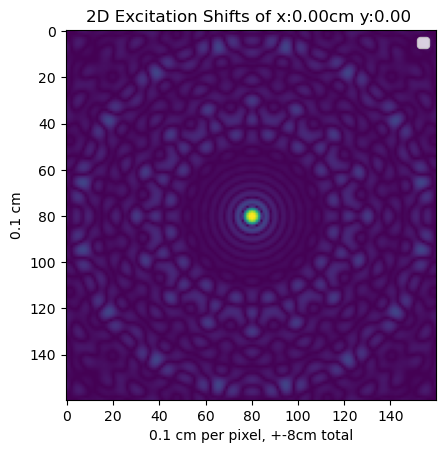

In [ ]:
step = 0.1
x = np.arange(-8,8, step)
y = np.arange(-8,8, step)

gs = 2*np.pi*4.257*g*dt  #g is G/cm gradfield, gs is spatial freq; gamma*g*dt in kHz. 
a,b = abrm(rf[:-1],gs,x,y)
mxy2 = ab2ex(a,b)



/tmp/ipykernel_2082/860133226.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


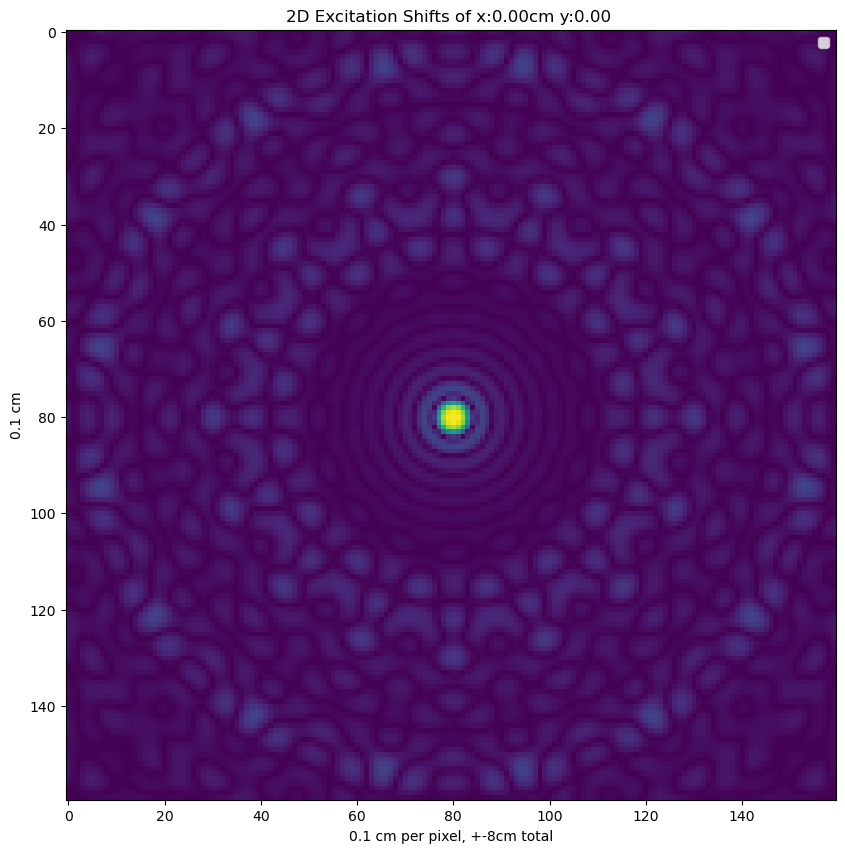

In [144]:
plt.figure(figsize=(10,10))
plt.title(f"2D Excitation Shifts of x:{shift_x:0.2f}cm y:{shift_y:0.2f} ")
plt.xlabel(f"{step} cm per pixel, +-8cm total")
plt.ylabel(f"{step} cm")
#plt.ylabel("|Mx| - Abs Excitation")
plt.imshow(np.abs(mxy2), label="|Mxy| excitation")
#plt.plot([-0.25,0.25],[0.2,0.2], label="dr= 0.5cm")
plt.legend()